In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [77]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [119]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * 10000
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [120]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            run_results = run_results
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results = np.multiply(all_results, 10000)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [121]:
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack/data/", 20, 6.2)
original_albo_slack_optim_results, original_albo_slack_optim_results_mean, original_albo_slack_optim_results_median, original_albo_slack_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim/data/", 20, 6.2)
original_albo_slack_no_optim_results, original_albo_slack_no_optim_results_mean, original_albo_slack_no_optim_results_median, original_albo_slack_no_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim/data/", 20, 6.2)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 20, 62000)
ts_al_adam_no_prev_rbf_results, ts_al_adam_no_prev_rbf_results_mean, ts_al_adam_no_prev_rbf_results_median, ts_al_adam_no_prev_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf/data/", 20, 62000)
ts_al_random_rbf_results, ts_al_random_rbf_results_mean, ts_al_random_rbf_results_median, ts_al_random_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/no_opt_rbf/data/", 20, 62000)

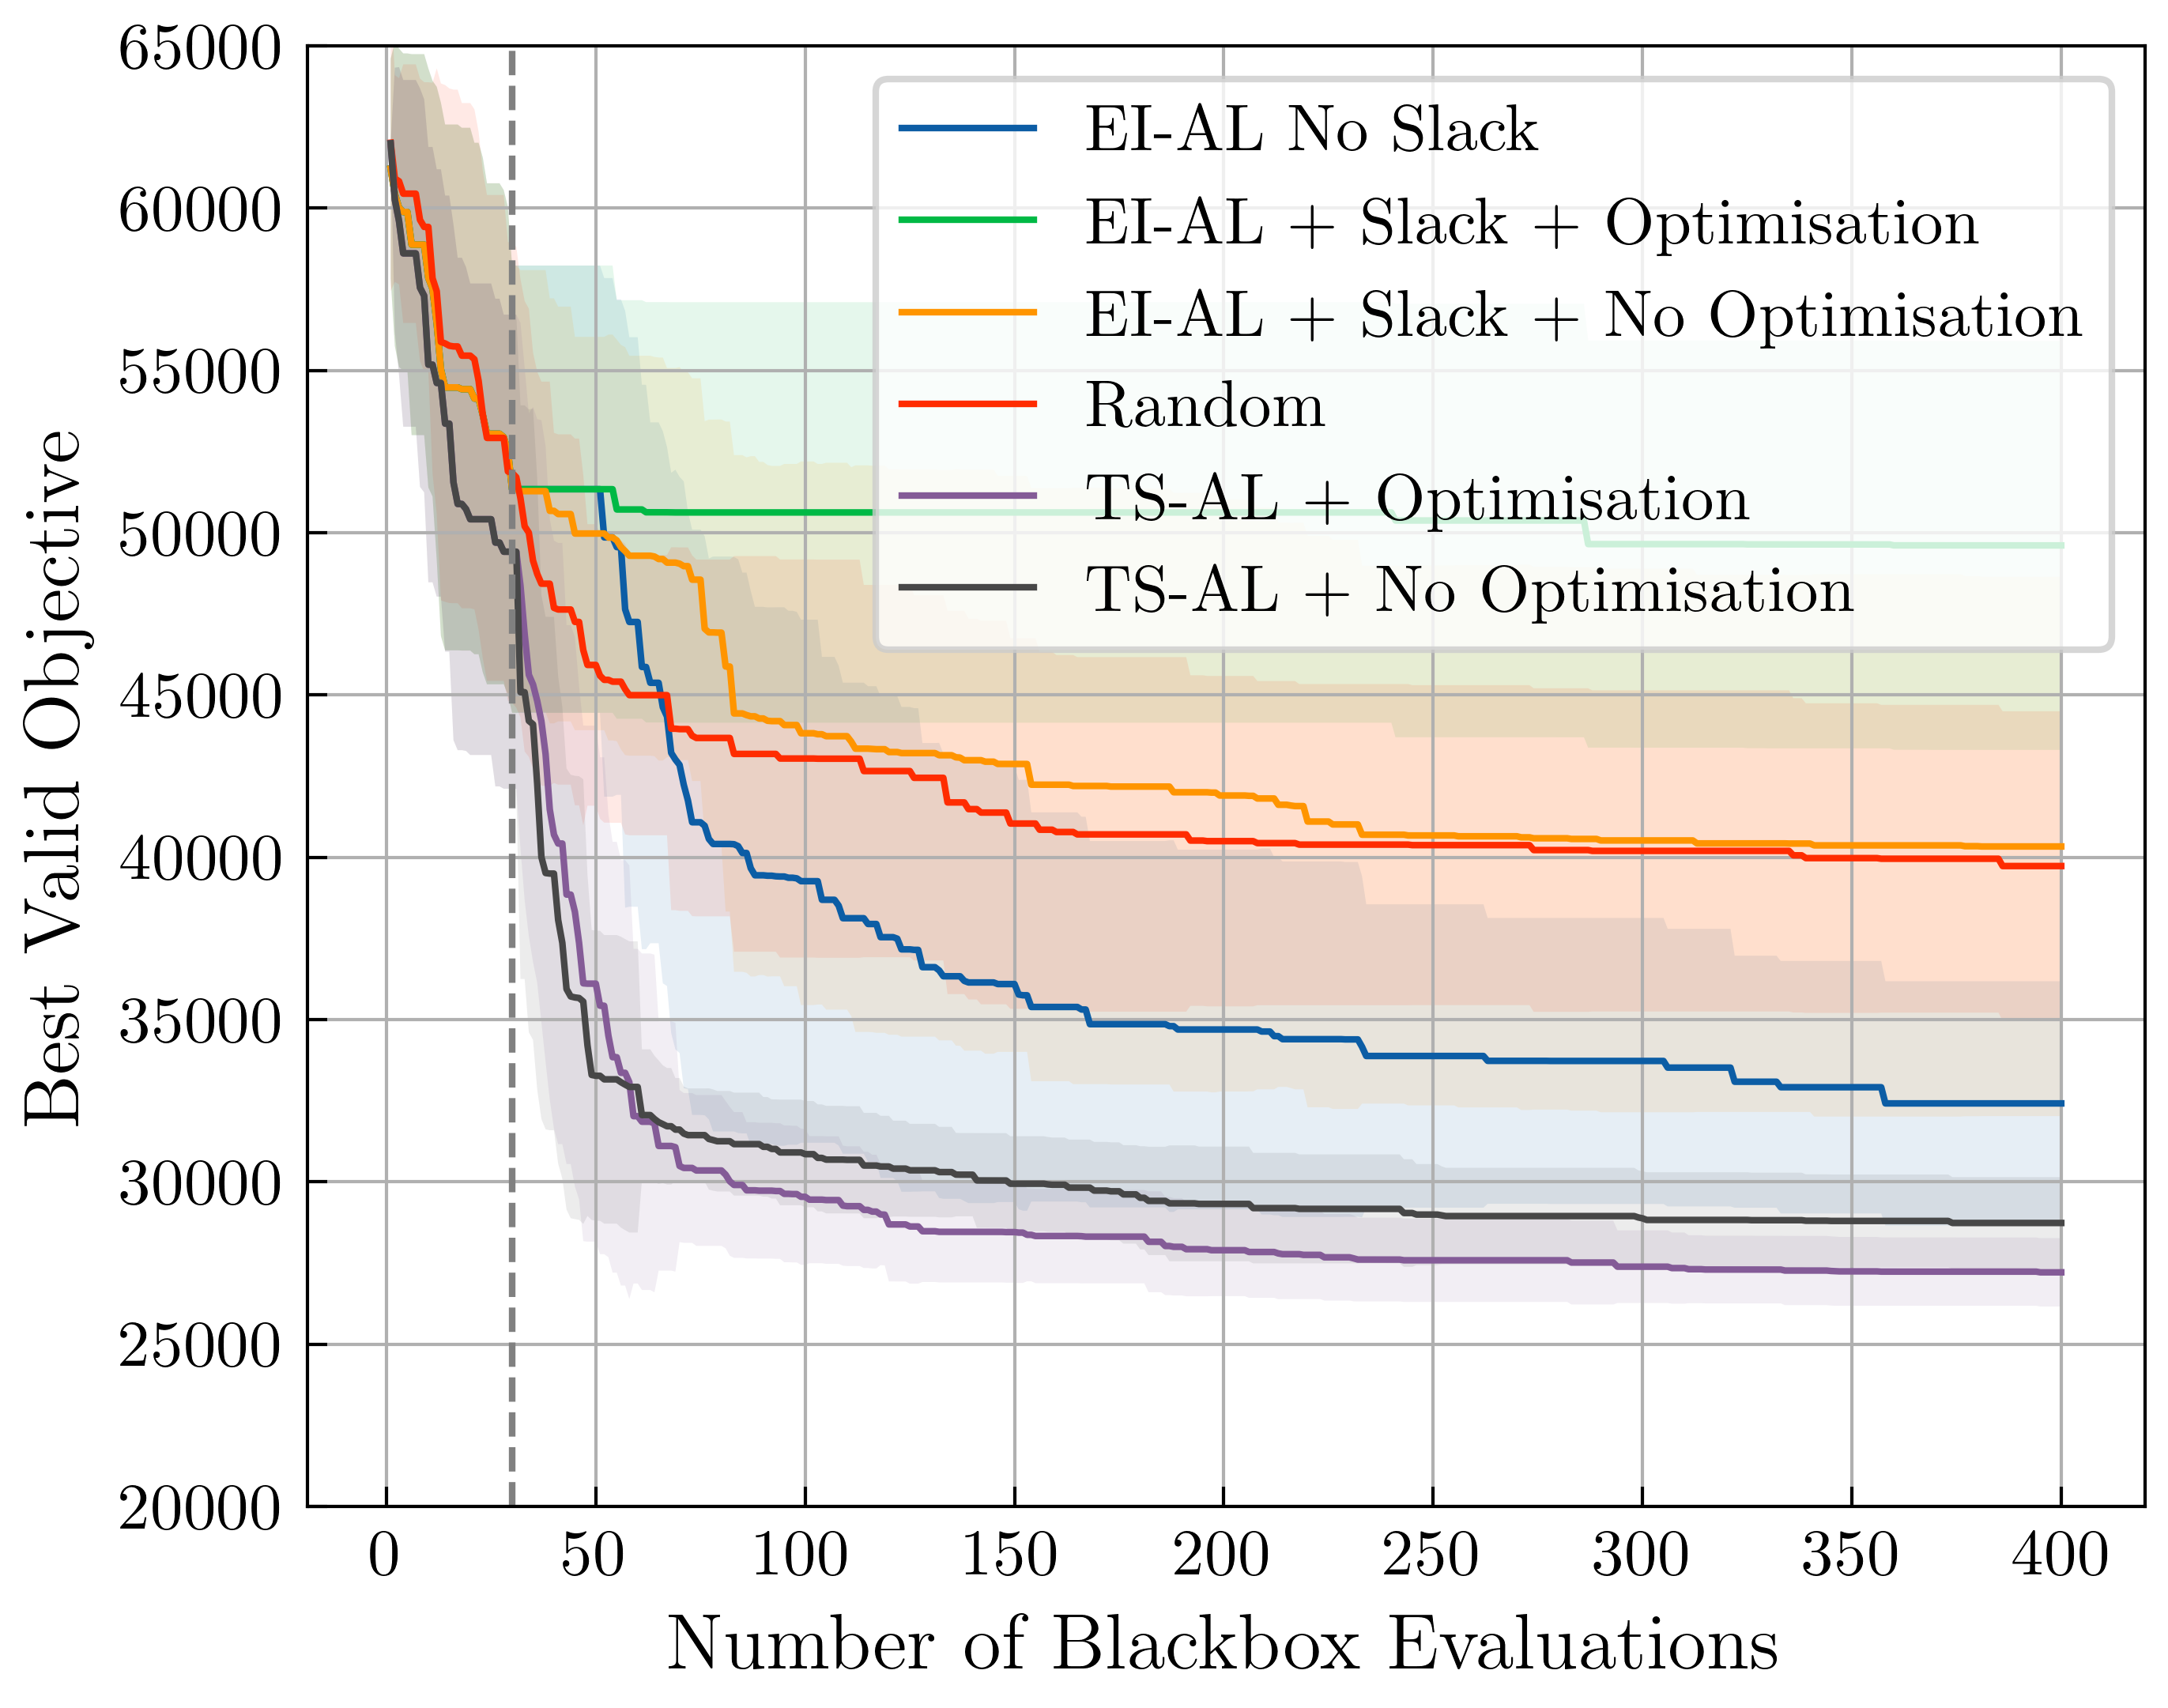

In [81]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 401)]
plt.plot(iters, original_albo_no_slack_results_mean, label="EI-AL No Slack")
plt.plot(iters, original_albo_slack_optim_results_mean, label="EI-AL + Slack + Optimisation")
plt.plot(iters, original_albo_slack_no_optim_results_mean, label="EI-AL + Slack + No Optimisation")
plt.plot(iters, random_results_mean[:400], label="Random")
plt.plot(iters, ts_al_adam_no_prev_rbf_results_mean, label="TS-AL + Optimisation")
plt.plot(iters, ts_al_random_rbf_results_mean, label="TS-AL + No Optimisation")
plt.axvline(x=30, color='grey', linestyle='--')
plt.fill_between(iters, original_albo_no_slack_results_mean+original_albo_no_slack_results_std, original_albo_no_slack_results_mean-original_albo_no_slack_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_optim_results_mean+original_albo_slack_optim_results_std, original_albo_slack_optim_results_mean-original_albo_slack_optim_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_no_optim_results_mean+original_albo_slack_no_optim_results_std, original_albo_slack_no_optim_results_mean-original_albo_slack_no_optim_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_results_mean[:400]+random_results_std[:400], random_results_mean[:400]-random_results_std[:400], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_results_mean+ts_al_adam_no_prev_rbf_results_std, ts_al_adam_no_prev_rbf_results_mean-ts_al_adam_no_prev_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_random_rbf_results_mean+ts_al_random_rbf_results_std, ts_al_random_rbf_results_mean-ts_al_random_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.savefig("figs/lockwood_results.png")
plt.show()

In [87]:
key_iterations = [100, 250, 400]

In [88]:
# TS-AL Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_adam_no_prev_rbf_results, 5, axis=0)[iter-1]}, Median: {ts_al_adam_no_prev_rbf_results_median[iter-1]}, 95%: {np.percentile(ts_al_adam_no_prev_rbf_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27232.422000000002, Median: 29134.585, 95%: 33529.922
Iter: 250
5%: 25516.665, Median: 27589.020000000004, 95%: 29299.180500000002
Iter: 400
5%: 25516.665, Median: 27407.334999999995, 95%: 28578.3315


In [89]:
# TS-AL No Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_random_rbf_results, 5, axis=0)[iter-1]}, Median: {ts_al_random_rbf_results_median[iter-1]}, 95%: {np.percentile(ts_al_random_rbf_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 28372.751, Median: 30765.160000000003, 95%: 33089.6255
Iter: 250
5%: 27029.529, Median: 28847.28, 95%: 31960.808
Iter: 400
5%: 27029.529, Median: 28550.850000000002, 95%: 31477.764


In [90]:
# EI-AL No Slack
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_slack_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_slack_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_slack_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 28123.395500000002, Median: 40960.395, 95%: 50508.1635
Iter: 250
5%: 26638.905000000002, Median: 33913.94500000001, 95%: 41472.33149999999
Iter: 400
5%: 26638.905000000002, Median: 33106.82, 95%: 37165.823000000004


In [91]:
# EI-AL Slack No Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_no_optim_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_no_optim_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_no_optim_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 30636.114999999998, Median: 45468.645000000004, 95%: 56806.48500000001
Iter: 250
5%: 28826.915999999997, Median: 42092.86, 95%: 51997.75400000001
Iter: 400
5%: 28269.4255, Median: 41625.149999999994, 95%: 51748.041000000005


In [92]:
# EI-AL Slack Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_optim_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_optim_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_optim_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 41601.333000000006, Median: 49110.845, 95%: 61095.9325
Iter: 250
5%: 41601.333000000006, Median: 49110.840000000004, 95%: 61095.904
Iter: 400
5%: 41601.3235, Median: 47625.855, 95%: 61095.904


In [93]:
# Random
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(random_results, 5, axis=0)[iter-1]}, Median: {random_results_median[iter-1]}, 95%: {np.percentile(random_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 31033.052500000005, Median: 43112.805, 95%: 52780.487499999996
Iter: 250
5%: 31033.052500000005, Median: 40938.12, 95%: 46179.5555
Iter: 400
5%: 31033.052500000005, Median: 40508.05, 95%: 46134.822
